In [143]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from format_data import get_data

In [144]:
algorithms = ['PL', 'STC', 'CC', 'HLNC', 'OBNC', 'BE']

In [145]:
injection_experiments = ['phishing_having_IP_Address', 'bank_housing', 'monks1_attr3', 'biodeg_V29', 
                'credit_A1', 'sick_referral_source_other', 'soil_isns', 'vote_crime', 'ads_local', 'churn_voice_mail_plan']

In [146]:
noise_types = ['random', 'flip', 'bias', 'balanced_bias']

In [147]:
experiments = ['adult_sex_Male', 'adult_race_White', 'german_sex_Male', 'compas_sex', 'compas_race_Caucasian', 'ricci_Race_W', 'diabetes_race_Caucasian', 'titanic_sex']

In [148]:
# runs = {}
# for exp in experiments:
#     for alg in algorithms:
#         runs[f'{exp}_{alg}'] = mlflow.search_runs(experiment_names=[f'{exp}_{alg}'], order_by=['start_time DESC'])

# for run in runs:
#     runs[run] = runs[run].fillna(0)

# for run in runs:
#     runs[run].to_csv(f'fairness_results/{run}.csv', index=False)

In [149]:
runs = {}
for exp in experiments:
    for alg in algorithms:
        runs[f'{exp}_{alg}'] = pd.read_csv(f'fairness_results/{exp}_{alg}.csv')

for exp in injection_experiments:
    for alg in algorithms:
        runs[f'{exp}_{alg}'] = pd.read_csv(f'noiseinjection_results/{exp}_{alg}.csv')

In [150]:
metrics = [
    'accuracy',
    'roc_auc',
    'equal_opportunity_difference', 
    'predictive_equality_difference',
    'demographic_parity_difference',
    'equalized_odds_difference']

In [151]:
pred_metrics = ['accuracy', 'roc_auc']

fair_metrics = [
        'equal_opportunity_difference', 
        'predictive_equality_difference',
        'demographic_parity_difference',
        'equalized_odds_difference']

In [194]:
def map_noise_rate(noise_type, fairness_exp):
    fig = plt.figure(figsize=(17, 3))
    axs = fig.subplots(1, 4, sharey=True, sharex=True)

    for i in range(4):
        metric = fair_metrics[i]
        metric_values = []
        for noise_rate in [i/10 for i in range(1, 10)]:
            values = []
            for exp in injection_experiments:
                run = runs[f'{exp}_PL']
                values.append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['params.noise_type'] == noise_type) & (run['tags.test_set'] == 'noisy') & (run['tags.train_set'] == 'noisy')][f'metrics.{metric}'].values[0])
            metric_values.append(np.mean(values))

        axs[i].plot([i/10 for i in range(1, 10)], metric_values)

        run = runs[f'{fairness_exp}_PL']
        val = run.loc[(run['tags.test_set'] == 'noisy') & (run['tags.train_set'] == 'noisy')][f'metrics.{metric}'].values[0]

        axs[i].axhline(y=val, color='r', linestyle='-')
        for nr in range(9):
            if metric_values[nr] > val:
                if nr == 0:
                    break
                axs[i].axvspan((nr)/10, (nr+1)/10, alpha=0.3, color='red')
                break

        axs[i].set_title(metric)
        axs[i].set_xlabel('Noise Rate')

    plt.subplots_adjust(wspace=0.07)
    plt.suptitle(f'{fairness_exp}', y=1.05)
    plt.show()

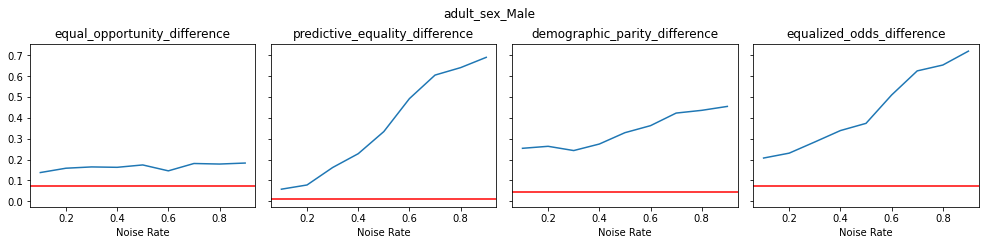

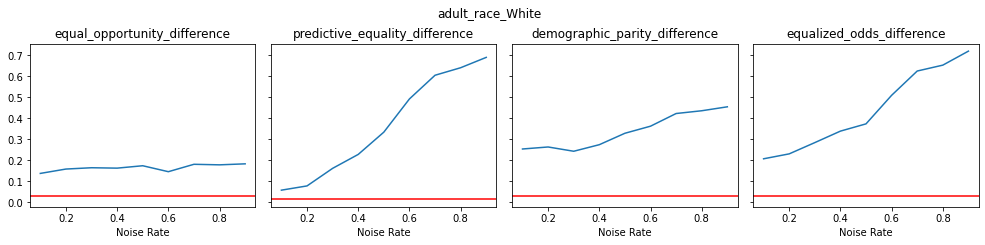

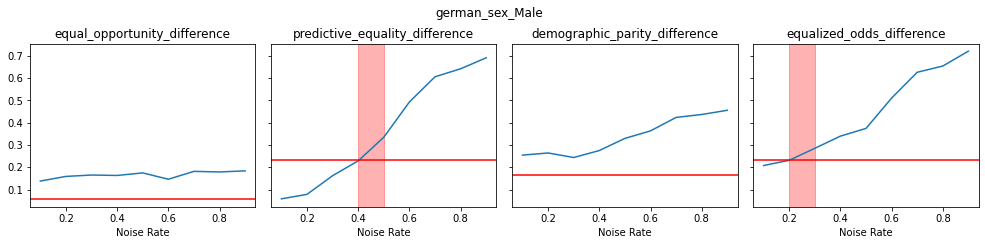

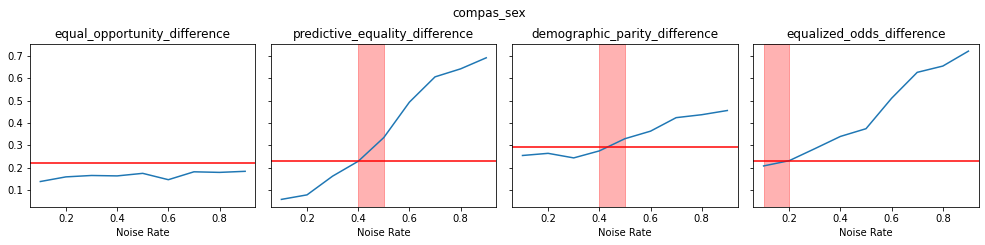

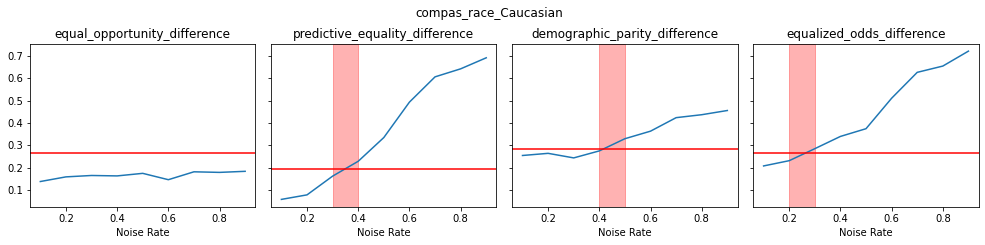

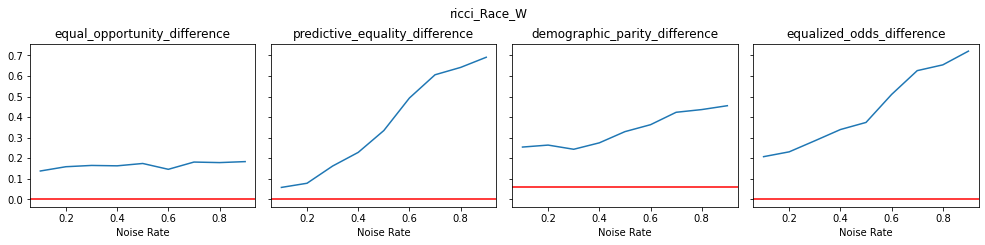

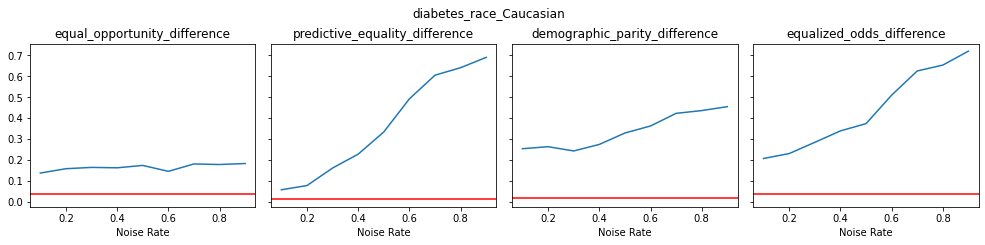

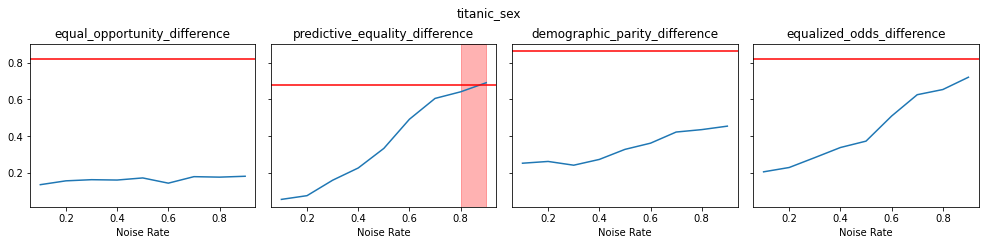

In [195]:
for exp in experiments:
    map_noise_rate('bias', exp)

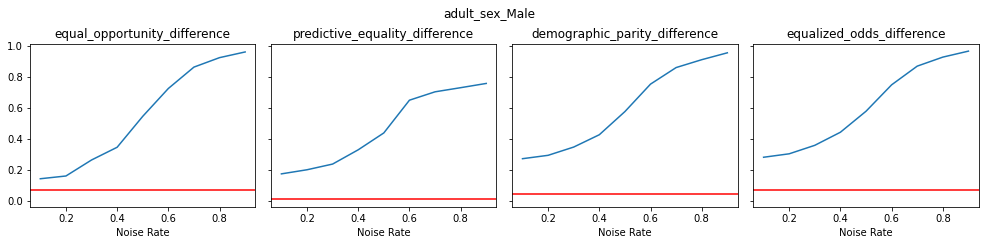

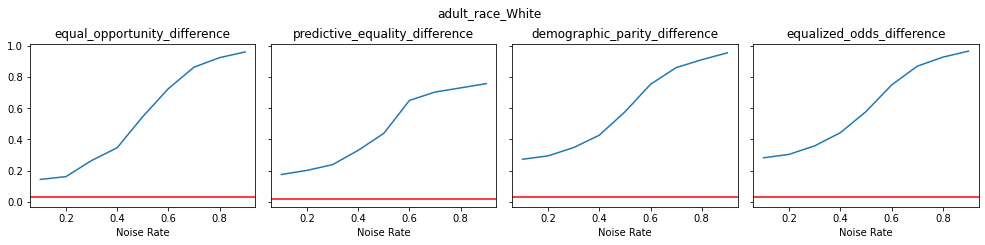

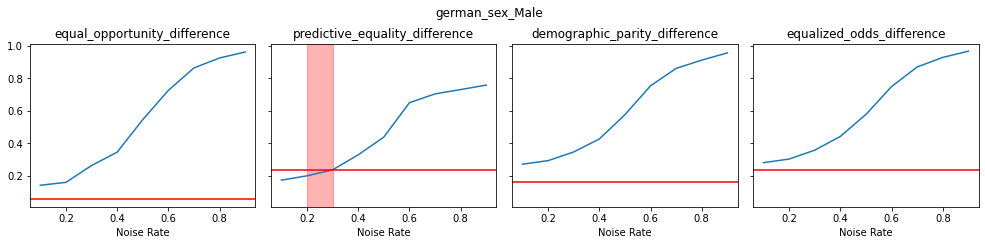

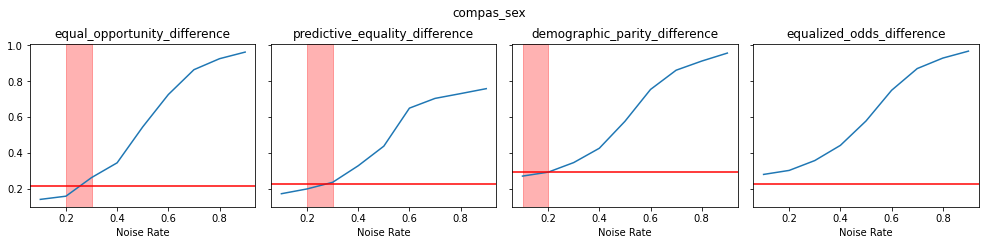

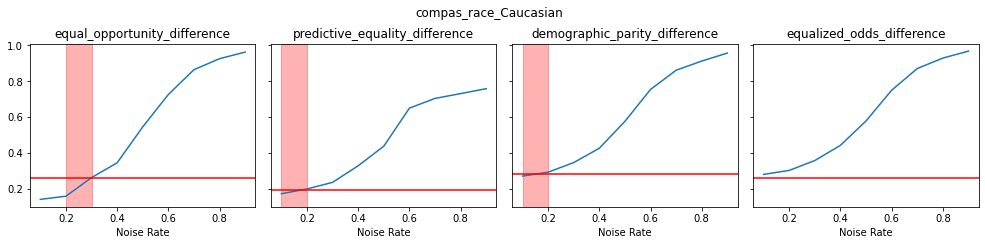

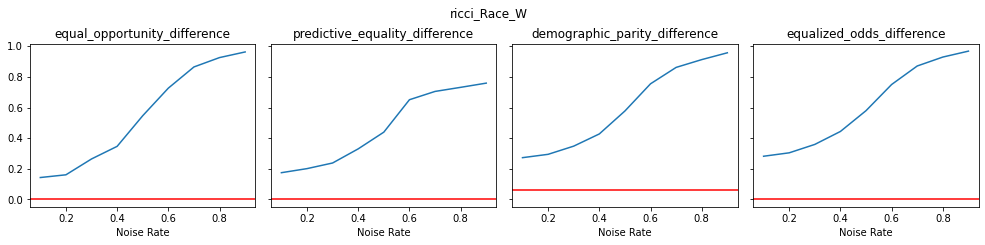

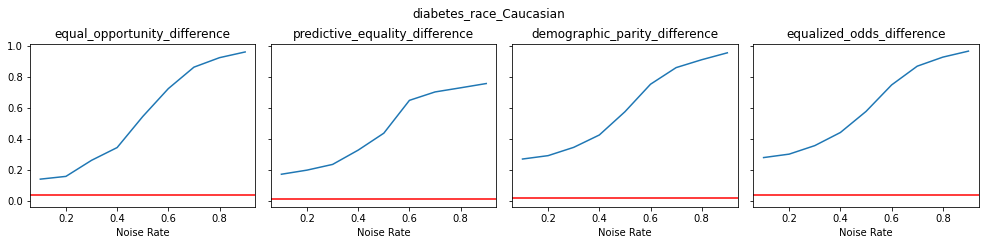

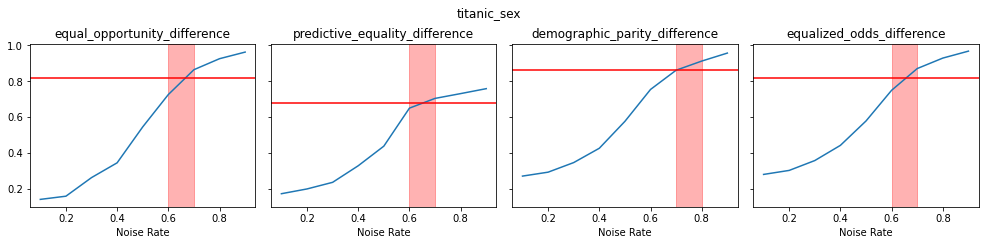

In [196]:
for exp in experiments:
    map_noise_rate('balanced_bias', exp)

# Titanic

In [163]:
data = pd.read_csv('data/titanic.csv')

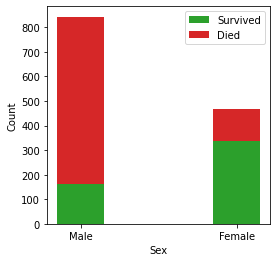

In [193]:
values = data[['sex', 'y']].value_counts()
X = ['Male', 'Female']
y_survived = [values[1, 1], values[0, 1]]
y_died = [values[1, 0], values[0, 0]]

plt.figure(figsize=(4, 4))
plt.bar(X, y_survived, 0.3, color='tab:green', label = 'Survived')
plt.bar(X, y_died, 0.3, bottom=y_survived, color='tab:red', label = 'Died')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend()
plt.show()

In [155]:
colors = {'PL':'tab:blue', 
          'STC':'tab:orange', 
          'CC':'tab:green', 
          'HLNC':'tab:red', 
          'OBNC':'tab:purple', 
          'BE':'tab:brown'}

In [215]:
def fairness_pred_trade_offs(exp, xlimit=None, ylimit=None):
    fig = plt.figure(figsize=(25, 8))
    axs = fig.subplots(2, 4, sharey=True, sharex=True)

    for i in range(2):
        pred_metric = pred_metrics[i]
        for j in range(4):
            fair_metric = fair_metrics[j]

            for alg in algorithms:
                run = runs[f'{exp}_{alg}']
                corr = run.loc[(run['tags.test_set'] == 'noisy') & (run['tags.train_set'] == 'corrected')]
                axs[i, j].scatter(corr[f'metrics.{fair_metric}'], corr[f'metrics.{pred_metric}'], label=alg, c=colors[alg])

            noisy = run.loc[(run['tags.test_set'] == 'noisy') & (run['tags.train_set'] == 'noisy')]
            axs[i, j].scatter(noisy[f'metrics.{fair_metric}'].values[0], noisy[f'metrics.{pred_metric}'].values[0], label='noisy', color='red', marker='x', s=100)
            axs[i, j].axhline(y=noisy[f'metrics.{pred_metric}'].values[0], color='r', linestyle='--', alpha=0.5)
            axs[i, j].axvline(x=noisy[f'metrics.{fair_metric}'].values[0], color='r', linestyle='--', alpha=0.5)

            if i == 1:
                axs[i, j].set_xlabel(fair_metric)
            if j == 0:
                axs[i, j].set_ylabel(pred_metric)

            if xlimit:
                axs[i, j].set_xlim(xlimit)
            if ylimit:
                axs[i, j].set_ylim(ylimit)

    axs[1, 3].legend()
    plt.subplots_adjust(wspace=0.07, hspace=0.07)
    plt.suptitle(f'Fairness/Accuracy Trade-Offs: {exp}', y=0.92)
    plt.show()

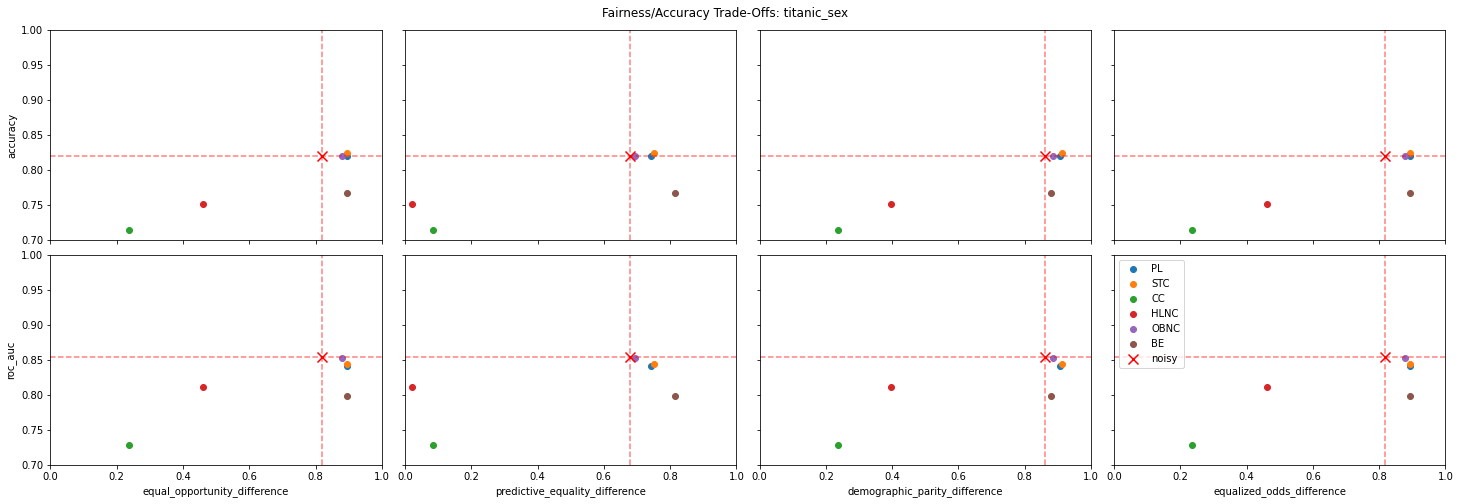

In [216]:
fairness_pred_trade_offs('titanic_sex', xlimit=(0, 1), ylimit=(0.7, 1))

In [224]:
def fairness_pred_trade_offs_corr_test_set(exp, alg, xlimit=None, ylimit=None):
    fig = plt.figure(figsize=(25, 8))
    axs = fig.subplots(2, 4, sharey=True, sharex=True)

    for i in range(2):
        pred_metric = pred_metrics[i]
        for j in range(4):
            fair_metric = fair_metrics[j]

            run = runs[f'{exp}_{alg}']

            corr = run.loc[(run['tags.test_set'] == 'corrected') & (run['tags.train_set'] == 'corrected')]
            axs[i, j].scatter(corr[f'metrics.{fair_metric}'], corr[f'metrics.{pred_metric}'], label=alg, c=colors[alg])

            noisy = run.loc[(run['tags.test_set'] == 'corrected') & (run['tags.train_set'] == 'noisy')]
            axs[i, j].scatter(noisy[f'metrics.{fair_metric}'].values[0], noisy[f'metrics.{pred_metric}'].values[0], label='noisy', color=colors[alg], marker='x', s=100)
            axs[i, j].axhline(y=noisy[f'metrics.{pred_metric}'].values[0], color=colors[alg], linestyle='--', alpha=0.5)
            axs[i, j].axvline(x=noisy[f'metrics.{fair_metric}'].values[0], color=colors[alg], linestyle='--', alpha=0.5)


            if i == 1:
                axs[i, j].set_xlabel(fair_metric)
            if j == 0:
                axs[i, j].set_ylabel(pred_metric)

            if xlimit:
                axs[i, j].set_xlim(xlimit)
            if ylimit:
                axs[i, j].set_ylim(ylimit)

    axs[1, 3].legend()
    plt.subplots_adjust(wspace=0.07, hspace=0.07)
    plt.show()

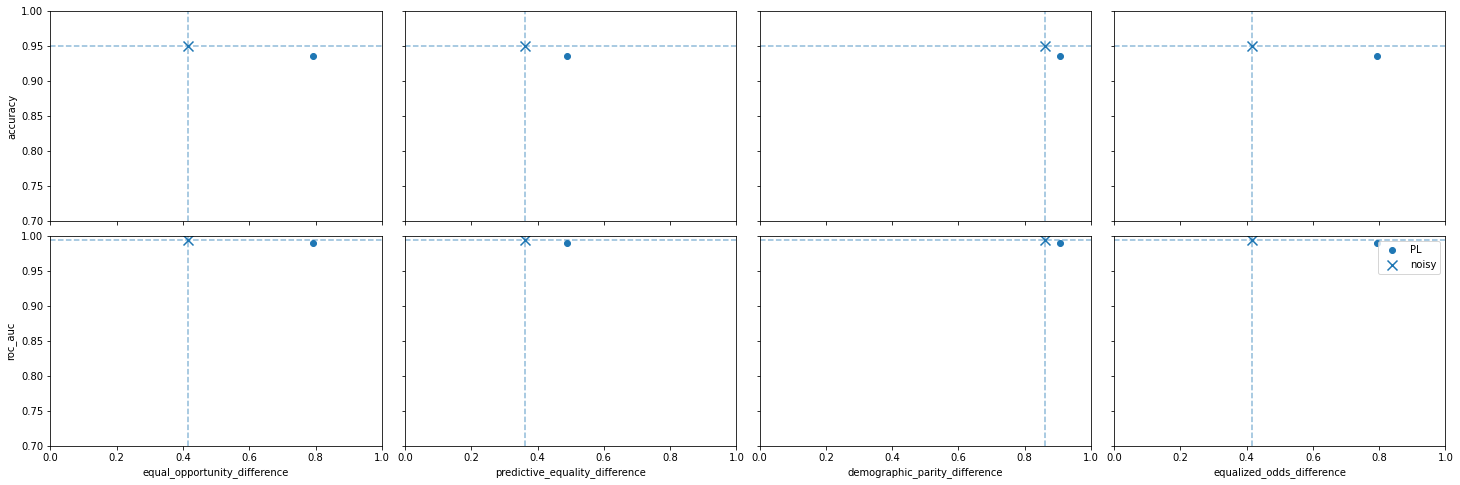

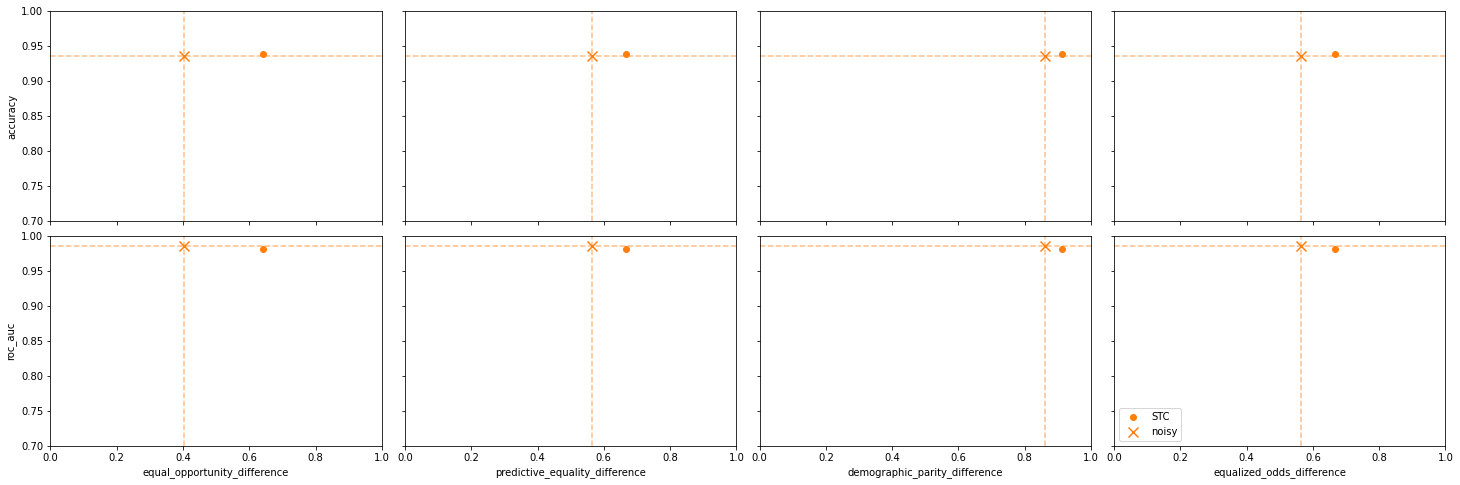

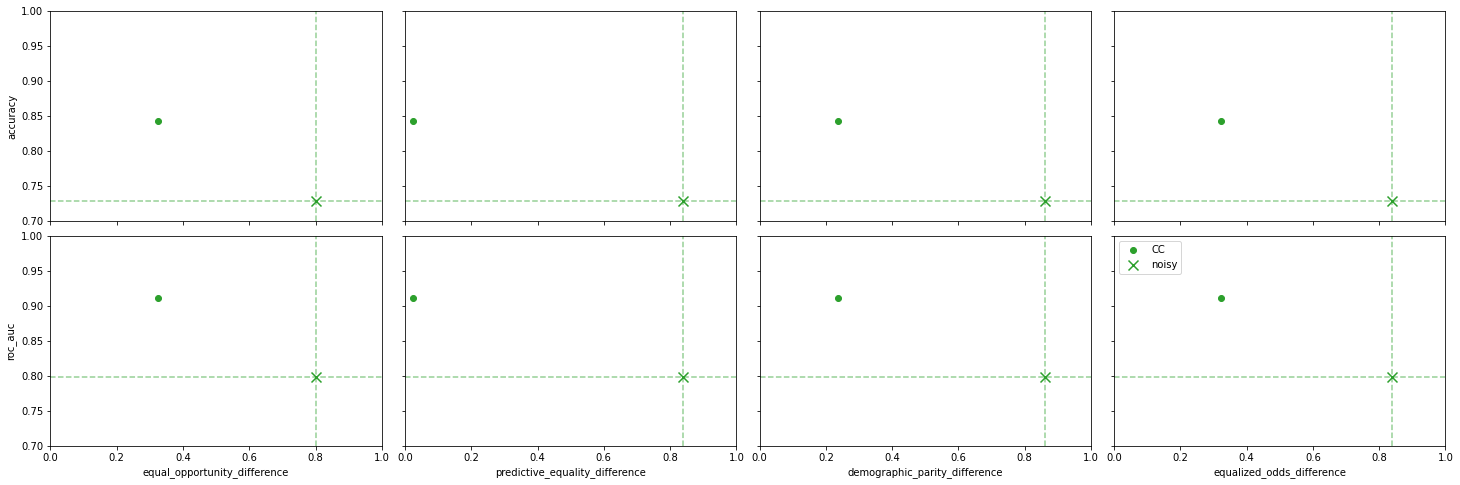

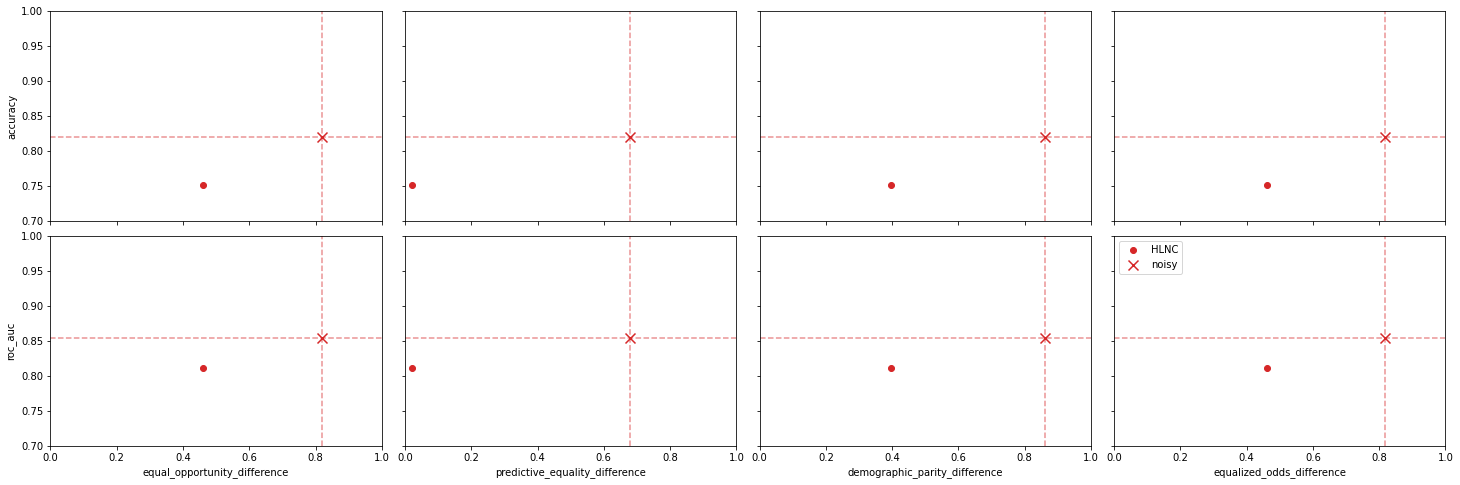

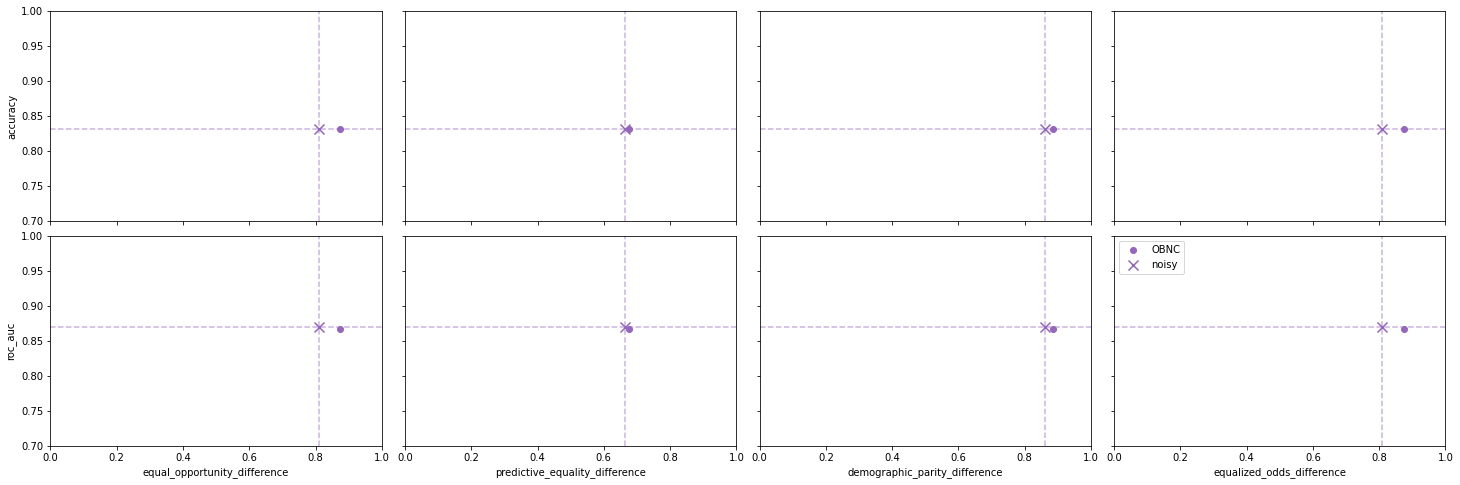

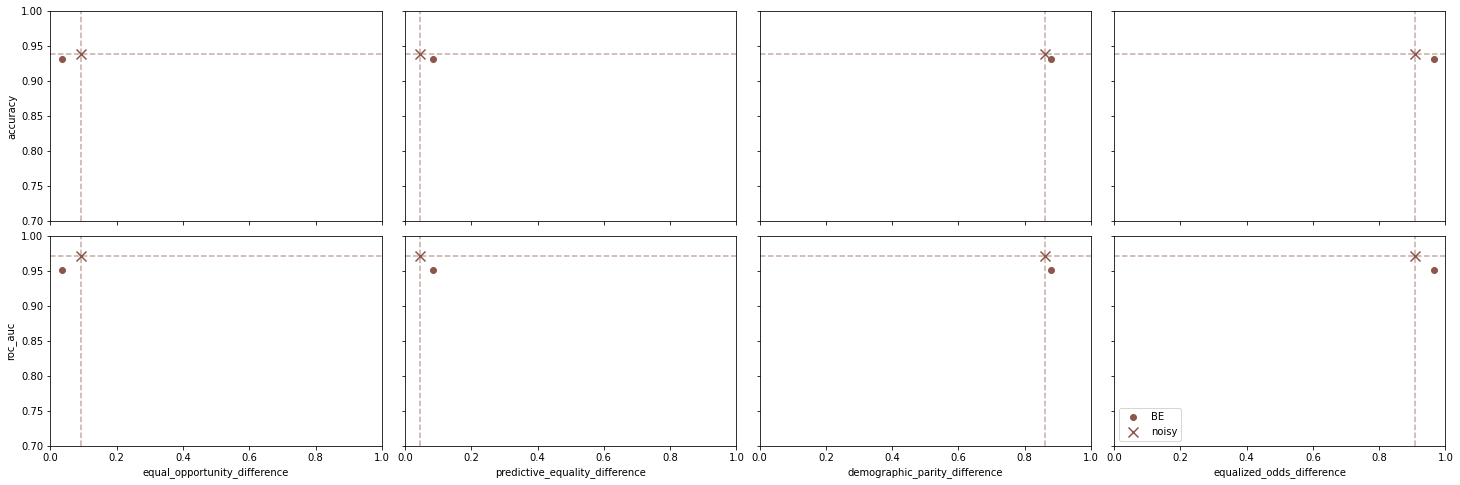

In [225]:
for alg in algorithms:
    fairness_pred_trade_offs_corr_test_set('titanic_sex', alg, xlimit=(0, 1), ylimit=(0.7, 1))

# COMPAS

In [227]:
data = pd.read_csv('data/compas.csv')

In [228]:
data

,sex,age,juv_misd_count,priors_count,age_cat_25-45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African-American,race_Caucasian,c_charge_degree_F,c_charge_degree_M,y
0,1,27,0,1,1,0,0,1,0,1,0,0
1,1,23,0,2,0,0,1,1,0,1,0,0
2,0,61,0,0,0,1,0,0,1,0,1,0
3,1,26,0,5,1,0,0,0,1,0,1,0
4,0,20,0,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4961,1,35,0,8,1,0,0,1,0,0,1,1
4962,0,20,0,0,0,0,1,1,0,0,1,1
4963,1,30,1,19,1,0,0,1,0,1,0,1
4964,1,21,0,0,0,0,1,0,1,0,1,1


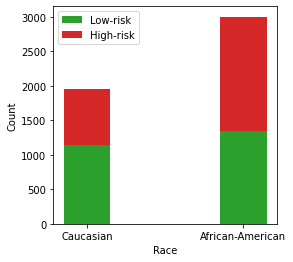

In [229]:
values = data[['race_Caucasian', 'y']].value_counts()
X = ['Caucasian', 'African-American']
y_riskhigh = [values[1, 1], values[0, 1]]
y_risklow = [values[1, 0], values[0, 0]]

plt.figure(figsize=(4, 4))
plt.bar(X, y_risklow, 0.3, color='tab:green', label = 'Low-risk')
plt.bar(X, y_riskhigh, 0.3, bottom=y_risklow, color='tab:red', label = 'High-risk')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend()
plt.show()

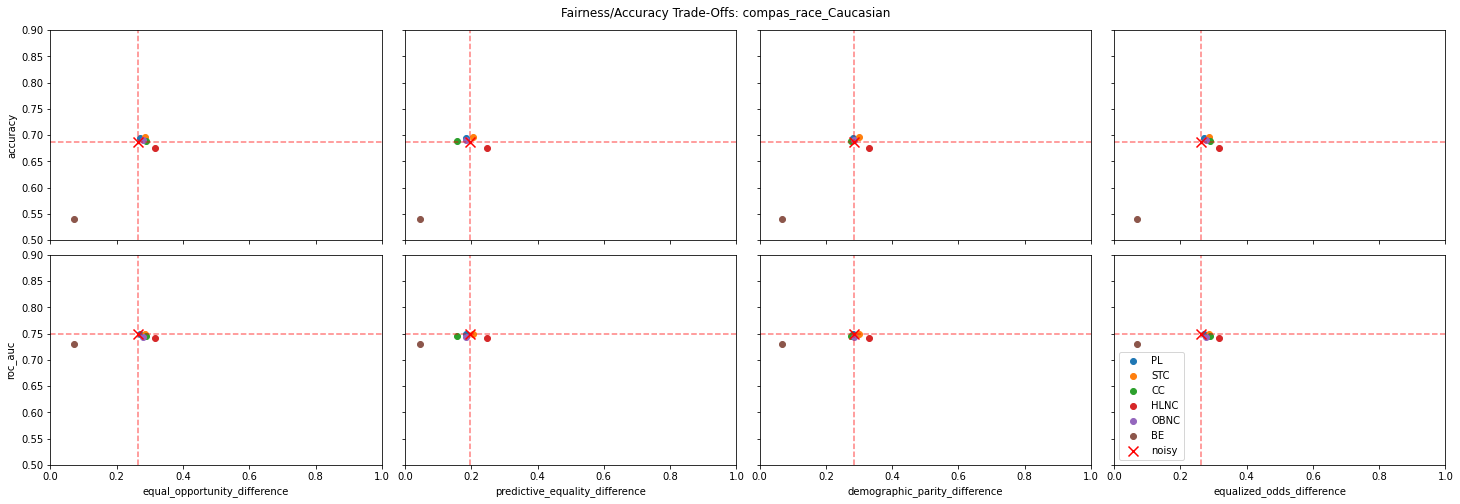

In [234]:
fairness_pred_trade_offs('compas_race_Caucasian', xlimit=(0, 1), ylimit=(0.5, 0.9))

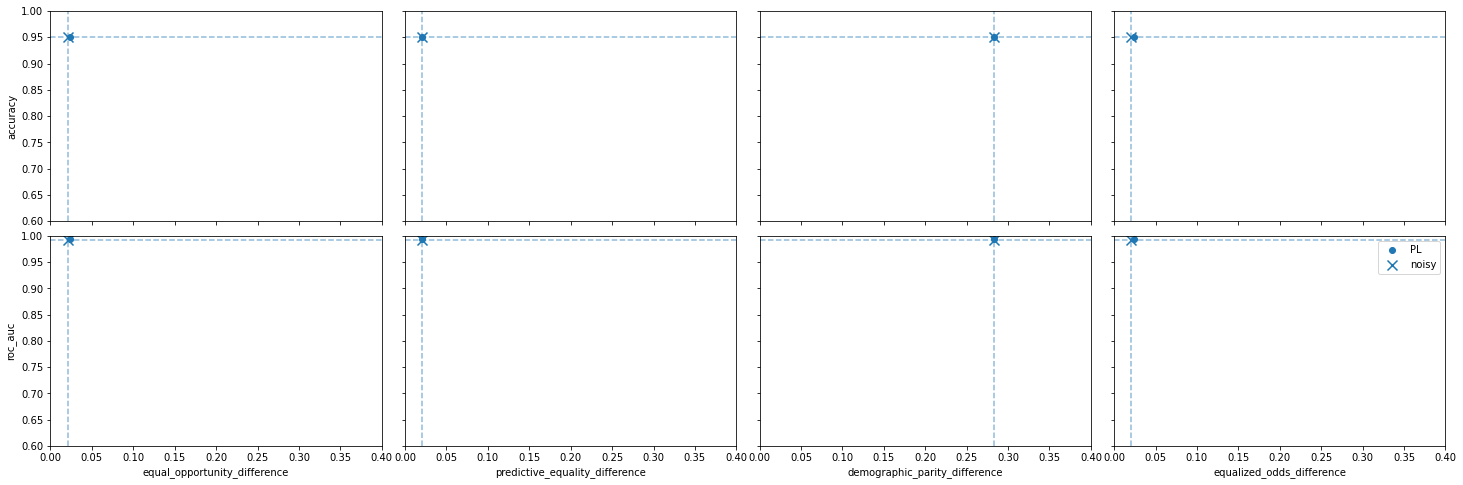

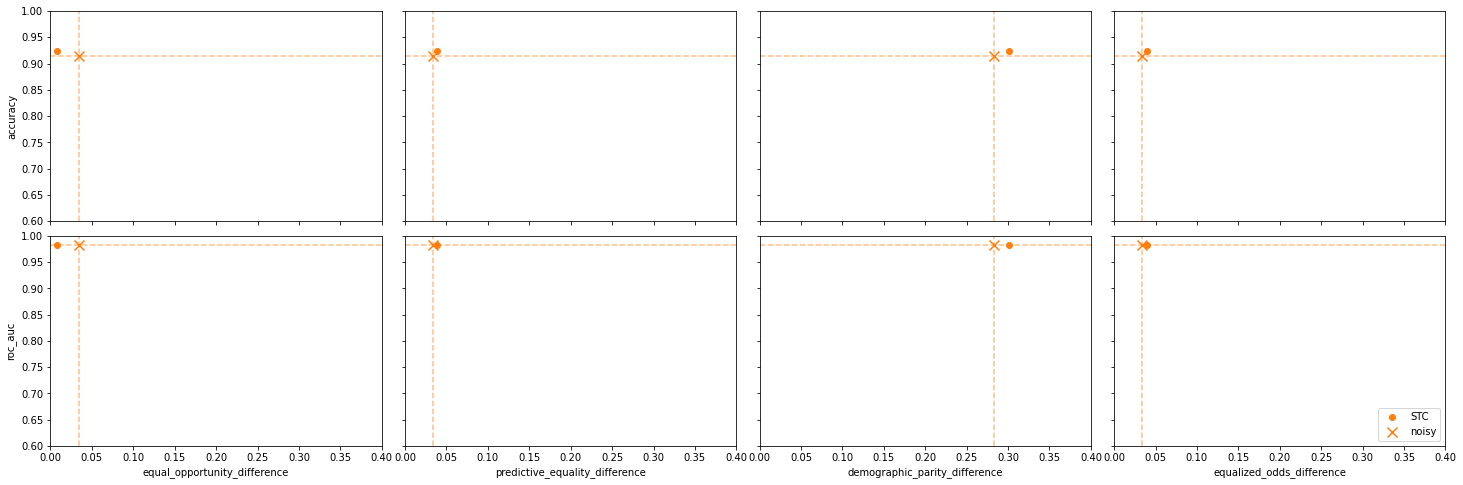

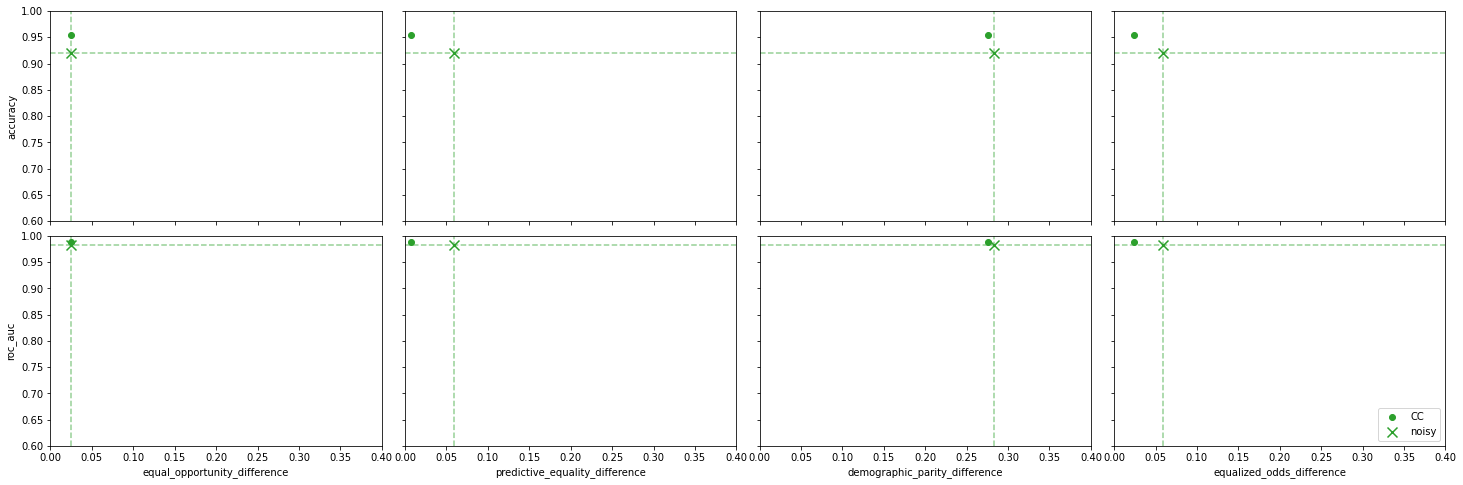

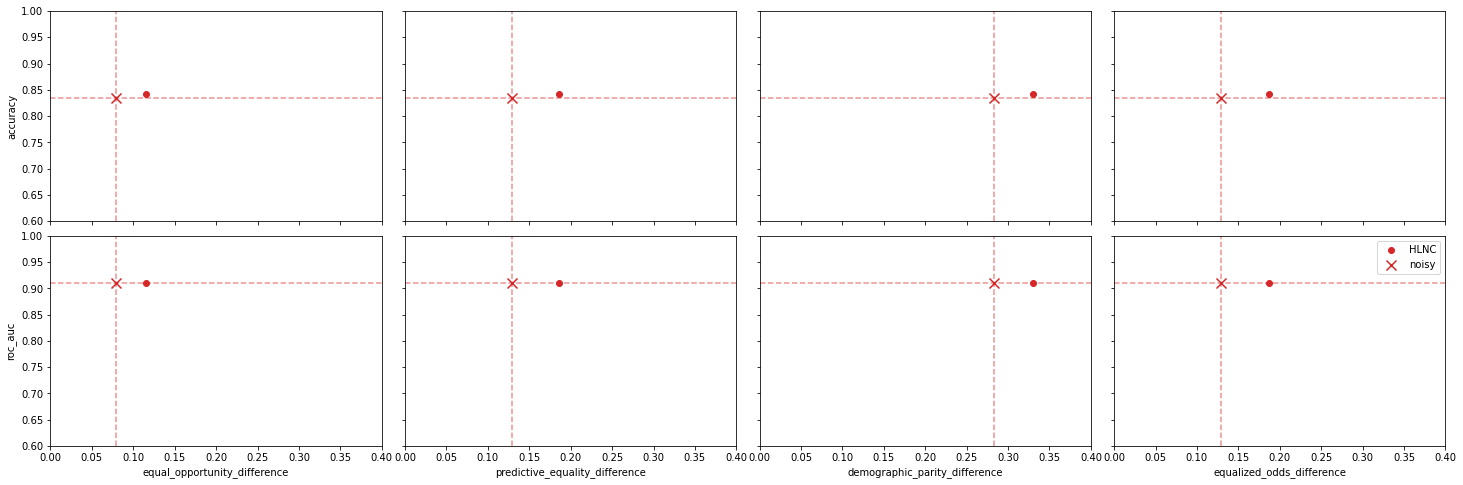

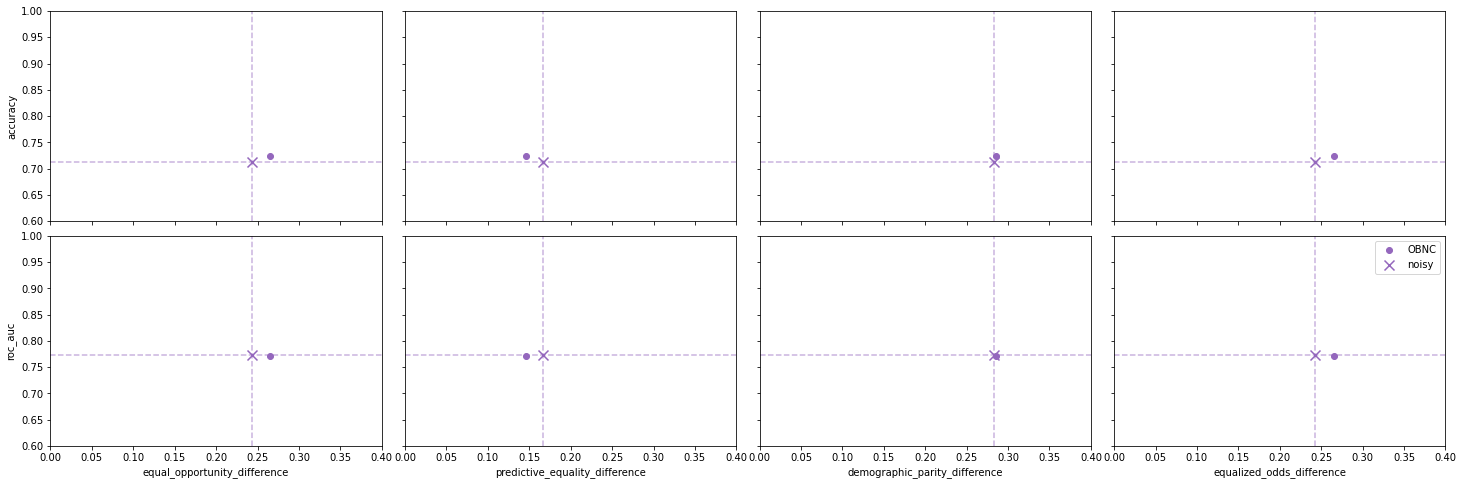

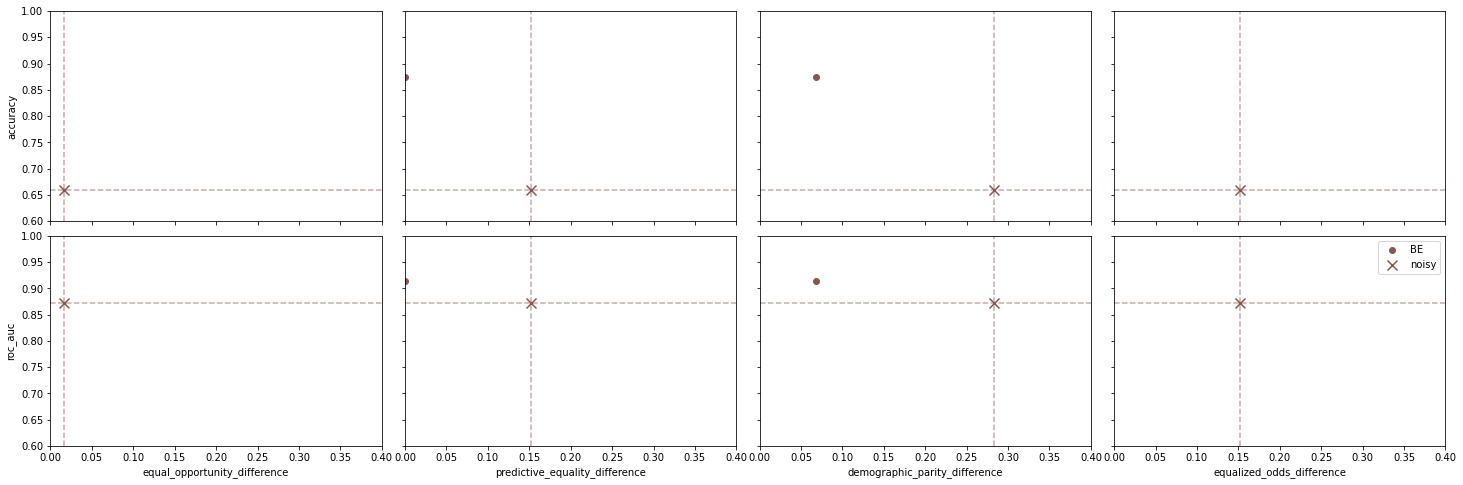

In [239]:
for alg in algorithms:
    fairness_pred_trade_offs_corr_test_set('compas_race_Caucasian', alg, xlimit=(0, 0.4), ylimit=(0.6, 1))